In [49]:
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyart

import boto3
import botocore
from botocore.client import Config

from metpy.io import Level2File
from metpy.plots import add_timestamp, ctables

#  32.5,  33.5
# -97.5, -96.5

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
filename = '/Volumes/Backup Plus/NEXRAD/data/2020-01-08/2020_01_08_KFWS_KFWS20200108_191600_V06'
f = pyart.io.read_nexrad_archive(filename)

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
f.add_field

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Radar.add_field of <pyart.core.radar.Radar object at 0x7f94be2a1f10>>

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


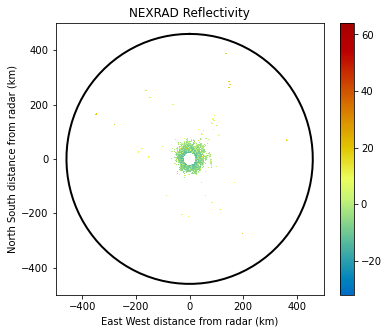

In [82]:
filename = '/Volumes/Backup Plus/NEXRAD/data/2020-01-08/2020_01_08_KFWS_KFWS20200108_191600_V06'
radar = pyart.io.read_nexrad_archive(filename)
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',
             vmin=-32, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)
plt.show()

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/pyart/map/gates_to_grid.py:160: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


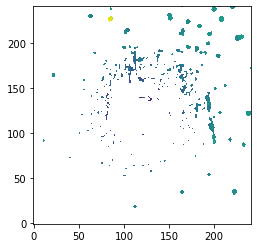

In [125]:
radar = pyart.io.read(filename)

# mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields['reflectivity']['data'][:, -10:] = np.ma.masked

# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (radar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 241, 241),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['reflectivity','velocity'])

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
plt.show()

/Users/Strawberry/opt/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


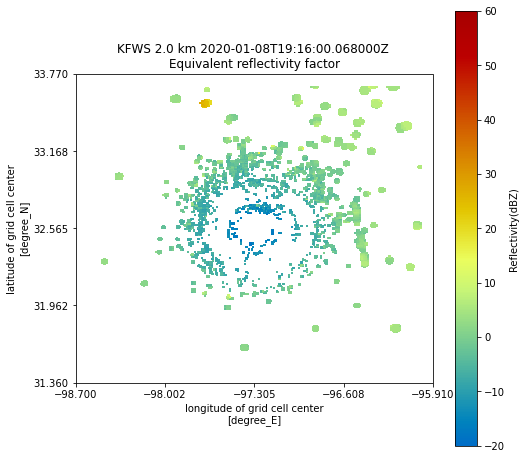

In [153]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity', level=0, vmin=-20, vmax=60)


In [2]:
R = 6371 * 1000 # radius of earth
def distance(lat1,long1, lat2, long2):
    # dx / R
    dx = math.radians(long1 - long2) * np.cos(math.radians(( lat1 + lat2)/2 ))
    # dy / R
    dy = math.radians(lat1 - lat2)
    # ds = R*sqrt(dx^2 + dy^2)
    h1 = R*np.sqrt(dx*dx + dy*dy)
    return h1

In [3]:
origin_latitude = 32.57861
origin_longitude = -97.303611
R = 6371 * 1000 # radius of earth
def xy2latlong(x, y): # based on origin_latitude, origin_longitude
    dlat_radians = y/R
    lat = origin_latitude + math.degrees(dlat_radians)
    dlon_radians = x/(R*math.cos(origin_latitude))
    long = origin_longitude + math.degrees(dlon_radians)
    
    return lat, long

In [4]:
year = '2020'
month = '02'
day = '01'
hour = '020000'

year_month = year + '-' + month
year_month_day = year_month + '-' + day

file_path = '/Volumes/Backup Plus/NEXRAD/halfyear/'+year_month+'/'+year_month_day+'/'+hour+'/'+year_month_day+'_'+hour+'.nc'
file_obj = nc.Dataset(file_path)


In [5]:
list(file_obj.variables.keys())

['time',
 'x',
 'y',
 'z',
 'origin_latitude',
 'origin_longitude',
 'origin_altitude',
 'projection',
 'ProjectionCoordinateSystem',
 'radar_latitude',
 'radar_longitude',
 'radar_altitude',
 'radar_time',
 'radar_name',
 'reflectivity',
 'velocity',
 'spectrum_width',
 'differential_phase',
 'differential_reflectivity',
 'cross_correlation_ratio',
 'ROI']

In [6]:
lats = []
longs = []
for i in range(len(file_obj['x'][:].data)):
    lat, long = xy2latlong(file_obj['x'][i], file_obj['y'][i])
    lats.append(lat)
    longs.append(long)

(54,)


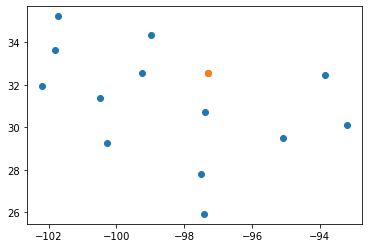

In [20]:
print(file_obj['x'][:].data.shape)
plt.scatter(file_obj['radar_longitude'][:].data, file_obj['radar_latitude'][:].data)
plt.scatter(file_obj['origin_longitude'][:].data, file_obj['origin_latitude'][:].data)
# plt.scatter(longs, lats)
# plt.xlim([-97.5, -96.5])
# plt.ylim([32.5,  33.5])

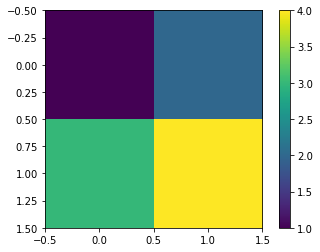

In [9]:
plt.imshow([[1,2],[3,4]])
plt.colorbar()

In [10]:
file_obj['reflectivity']

<class 'netCDF4._netCDF4.Variable'>
float32 reflectivity(time, z, y, x)
    _FillValue: -9999.0
    long_name: Reflectivity
    units: dBZ
    standard_name: equivalent_reflectivity_factor
    valid_max: 94.5
    valid_min: -32.0
    coordinates: elevation azimuth range
unlimited dimensions: time
current shape = (1, 11, 56, 54)
filling on

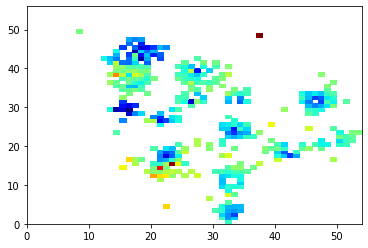

In [11]:
mat = file_obj['reflectivity'][0][0]
plt.pcolormesh(mat[:,:], cmap='jet')
# plt.xlim([-97.5, -96.5])
# plt.ylim([32.5,  33.5])

In [24]:
file_obj['reflectivity'][0][0].shape

(56, 54)

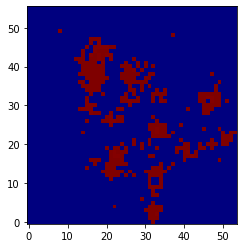

In [12]:
mat = file_obj['reflectivity'][0][0].data
plt.imshow(mat, cmap='jet', origin = 'lower')

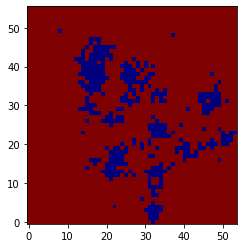

In [13]:
mat = file_obj['reflectivity'][0][0].mask
plt.imshow(mat, cmap='jet', origin = 'lower')

In [14]:
file_obj['time'].units

'seconds since 2020-02-01T02:00:06Z'

In [15]:
for var in file_obj.variables.keys():
    print(var, file_obj[var].shape)

time (1,)
x (54,)
y (56,)
z (11,)
origin_latitude (1,)
origin_longitude (1,)
origin_altitude (1,)
projection ()
ProjectionCoordinateSystem ()
radar_latitude (14,)
radar_longitude (14,)
radar_altitude (14,)
radar_time (14,)
radar_name (14, 4)
reflectivity (1, 11, 56, 54)
velocity (1, 11, 56, 54)
spectrum_width (1, 11, 56, 54)
differential_phase (1, 11, 56, 54)
differential_reflectivity (1, 11, 56, 54)
cross_correlation_ratio (1, 11, 56, 54)
ROI (1, 11, 56, 54)


In [16]:
file_obj['z'][:]

masked_array(data=[    0. ,  1000.1,  2000.2,  3000.3,  4000.4,  5000.5,
                    6000.6,  7000.7,  8000.8,  9000.9, 10001. ],
             mask=False,
       fill_value=1e+20)

In [23]:
for var in [ 'reflectivity',
 'velocity',
 'spectrum_width',
 'differential_phase',
 'differential_reflectivity',
 'cross_correlation_ratio',
 'ROI']:
    print(var)
    print(file_obj[var][0][0].fill_value)


reflectivity
-9999.0
velocity
-9999.0
spectrum_width
-9999.0
differential_phase
-9999.0
differential_reflectivity
-9999.0
cross_correlation_ratio
-9999.0
ROI
1e+20


In [22]:
file_obj['reflectivity'][0][0].fill_value

-9999.0